# Transfer Learning

전이 학습(Transfer Learning)은 기존의 학습된 모델을 사용하여 새로운 모델을 만들 때, 더 빠른 학습과 예측 성능을 높이는 방법입니다.

전이 학습을 사용하는 이유는 아래와 같습니다.

1.기존에 학습이 잘된 모델들이 많음

2.복잡한 모델일수록 새로운 학습에 많은 연산량, 메모리, 시간이 소요됨  

3.실질적으로 처음부터 새로운 모델을 학습시키기 어려운 경우 사용

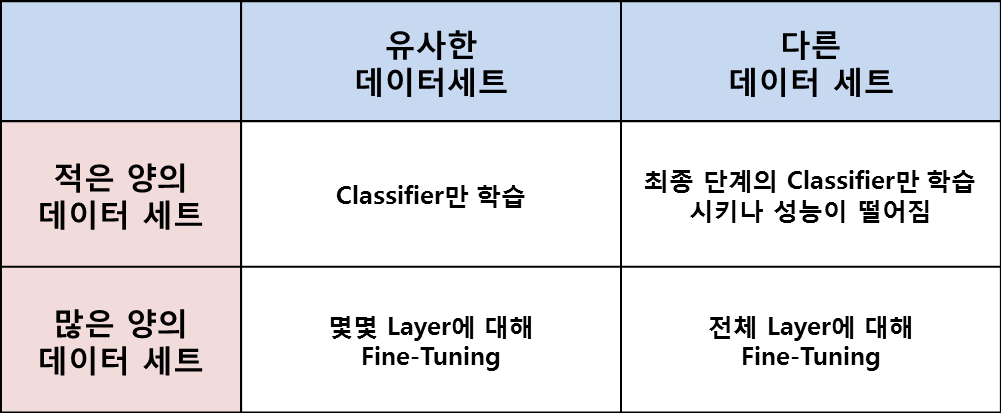

In [2]:
from IPython.display import Image
Image('./Transfer_learning.png')

1. 적은 양의 유사 데이터
- 데이터의 양이 적기 때문에 Overfitting을 방지하기 위해 뒤쪽의 Classifier만 학습

3. 적은 양의 다른 데이터
- 데이터의 양이 적기 때문에 뒤쪽의 Classifier만 학습하지만 성능 향상을 기대하기 힘듬

3. 많은 양의 유사 데이터
- Overfitting의 위험이 적으므로 전체 및 많은 Layer를 Fine-tuning

4. 많은 양의 다른 데이터
- 데이터가 다르기 때문에 전체 모델을 Fine-tunin

전이 학습 실습에서 (0 ~ 4)의 MNIST 데이터만 학습시키고 (5 ~ 9)의 MNIST 데이터로 검증을 해보면 당연히 Test accuracy는 굉장히 낮습니다.

(0 ~ 4)의 MNIST 데이터로만 학습된 모델에 전이 학습을 적용시키기 위한 몇가지 작업을 이번 실습에서 진행해보겠습니다.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 32)                32800     
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1

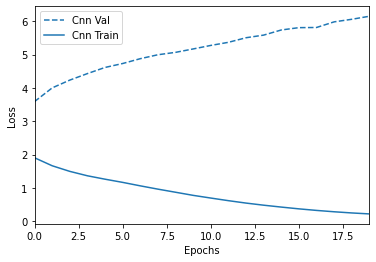

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.utils import to_categorical

# 시각화 함수
def Visulaize(histories, key='loss'):
    for name, history in histories:
        val = plt.plot(history.epoch, history.history['val_'+key],
                   '--', label=name.title()+' Val')
        plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
             label=name.title()+' Train')

    plt.xlabel('Epochs')
    plt.ylabel(key.replace('_',' ').title())
    plt.legend()
    plt.xlim([0,max(history.epoch)])
    plt.savefig("plot.png")
    
def main():

    # MNIST 데이터 세트를 불러오고 Train과 Test를 나누어줍니다.
    mnist = np.load('./data/mnist.npz')
    X_train, X_test, y_train, y_test = mnist['x_train'][:5000], mnist['x_test'][:1000], mnist['y_train'][:5000], mnist['y_test'][:1000]

    # Transfer Learning을 위해 MNIST 데이터를 나누어줍니다.
    # Label값 (0 ~ 4 / 5 ~ 9)에 따라 5개씩 나누어줍니다.
    x_mnist_04 = []
    y_mnist_04 = []
    x_mnist_59 = []
    y_mnist_59 = []

    for idx, label in enumerate(y_train):
        if label <= 4:
            x_mnist_04.append(X_train[idx])
            y_mnist_04.append(y_train[idx])

        else:
            x_mnist_59.append(X_train[idx])
            y_mnist_59.append(y_train[idx])

    # (0 ~ 4)의 데이터로 학습하고 (5 ~ 9)의 데이터로 검증을 해보겠습니다.
    X_train04, y_train04 = np.array(x_mnist_04), np.array(y_mnist_04)
    X_test59, y_test59 = np.array(x_mnist_59), np.array(y_mnist_59)

    # 나눈 MNIST 데이터 전처리
    X_train04 = X_train04.astype(np.float32) / 255.
    X_test59 = X_test59.astype(np.float32) / 255.

    X_train04 = np.expand_dims(X_train04, axis=-1)
    X_test59 = np.expand_dims(X_test59, axis=-1)

    y_train04 = to_categorical(y_train04, 10)
    y_test59 = to_categorical(y_test59, 10)

    # CNN 모델 선언
    CNN_model = keras.Sequential([
        keras.layers.Conv2D(32 ,kernel_size = (3,3), strides = (2,2), padding = 'same', activation=tf.nn.relu, input_shape=(28,28,1)),
        keras.layers.Conv2D(64 ,kernel_size = (3,3), strides = (2,2), padding = 'same', activation=tf.nn.relu),
        keras.layers.Conv2D(64 ,kernel_size = (3,3), strides = (2,2), padding = 'same', activation=tf.nn.relu),
        keras.layers.Flatten(),
        keras.layers.Dense(32, activation=tf.nn.sigmoid),
        keras.layers.Dense(16, activation=tf.nn.sigmoid),
        keras.layers.Dense(10, activation=tf.nn.softmax)
    ])

    # CNN model을 학습시켜줍니다.
    CNN_model.compile(optimizer='adam',loss='categorical_crossentropy', metrics = ['accuracy'])
    CNN_model.summary()

    '''
    지시사항 1,2번
    [0 ~ 4] Label의 데이터로 `CNN_model`을 학습시키고 [5 ~ 9] Label의 데이터로 `CNN_model`을 검증해보세요.
    '''
    CNN_history = CNN_model.fit(X_train04, y_train04,epochs= 20, batch_size = 100, validation_data=(X_test59, y_test59), verbose=2)

    '''
    지시사항 3번
    학습이 어떻게 이루어졌는지 확인합니다.
    '''
    Visulaize([('CNN', CNN_history)])


    ################################################################################
    # Transfer Learning을 위한 과정입니다.
    # 학습된 CNN_model의 Classifier 부분인 Flatten() - Dense() layer를 제거해줍니다.
    CNN_model.summary()
    
    '''
    지시사항 4번
    총 3개의 Dense layer와 1개의 Flatten layer가 있으므로 4번 pop을 해줍니다.
    '''
    CNN_model.pop()
    CNN_model.pop()
    CNN_model.pop()
    CNN_model.pop()
    

    # Classifier를 지운 모델의 구조를 확인합니다.
    CNN_model.summary()

    # 이제 CNN_model에는 학습된 Convolution Layer만 남아있습니다.

    # Convolution Layer의 학습된 Weight들을 저장합니다.
    CNN_model.save_weights('CNN_model.h5', save_format='h5')
    # 여기까지가 Transfer Learning의 1차 과정입니다.
    # 다음 실습에서 이어서 Transfer Learning을 진행하겠습니다.

    return CNN_model.summary()

if __name__ == "__main__":
    main()

1. convolution, flatten, mlp 로 모델을 만든다.
2. model optimizer와 loss function을 설정해준다.
3. 첫번째 train 데이터로 model을 학습시킨다.
4. flatten, mlp를 pop하여 없앤다.
5. 'CNN_model.h5' 라는 이름으로 저장한다.

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                10250     
_________________________________________________________________
dense_4 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_5 (Dense)              (None, 10)               

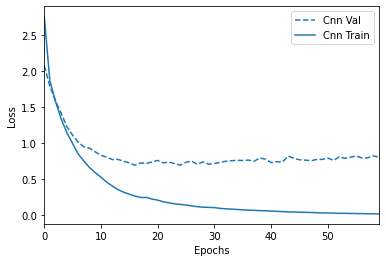

In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.utils import to_categorical

# 시각화 함수
def Visulaize(histories, key='loss'):
    for name, history in histories:
        val = plt.plot(history.epoch, history.history['val_'+key],
                   '--', label=name.title()+' Val')
        plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
             label=name.title()+' Train')

    plt.xlabel('Epochs')
    plt.ylabel(key.replace('_',' ').title())
    plt.legend()
    plt.xlim([0,max(history.epoch)])
    plt.savefig("plot.png")
    

def main():

    # MNIST Data를 Train과 Test로 나누어줍니다.
    mnist = np.load('./data/mnist.npz')
    X_train, X_test, y_train, y_test = mnist['x_train'][:500], mnist['x_test'][:500], mnist['y_train'][:500], mnist['y_test'][:500]

    # MNIST Data를 전저리합니다.
    X_train = X_train.astype(np.float32) / 255.
    X_test = X_test.astype(np.float32) / 255.

    X_train = np.expand_dims(X_train, axis=-1)
    X_test = np.expand_dims(X_test, axis=-1)

    y_train = to_categorical(y_train, 10)
    y_test = to_categorical(y_test, 10)

    # 이전 실습에서 사용했던 CNN_model과 같은 구조를 가진 모델을 선언합니다.
    # 저장된 Weights를 불러오기 위해서는 모델의 구조가 같아야합니다.
    Transfer_model = keras.Sequential([
        keras.layers.Conv2D(32 ,kernel_size = (3,3), strides = (2,2), padding = 'same', activation=tf.nn.relu, input_shape=(28,28,1)),
        keras.layers.Conv2D(64 ,kernel_size = (3,3), strides = (2,2), padding = 'same', activation=tf.nn.relu),
        keras.layers.Conv2D(64 ,kernel_size = (3,3), strides = (2,2), padding = 'same', activation=tf.nn.relu)
    ])

    '''
    지시사항 1번
    Transfer_model 모델에 학습된 Weight를 넣어주세요.
    '''
    Transfer_model.load_weights('./CNN_model.h5')
    
    
    '''
    지시사항 2번
    새로운 Classifier를 Transfer_model에 붙여주세요.
    '''
    Transfer_model.add(keras.layers.Flatten())
    Transfer_model.add(keras.layers.Dense(10, activation='relu'))
    Transfer_model.add(keras.layers.Dense(10, activation='relu'))
    Transfer_model.add(keras.layers.Dense(10, activation='softmax'))
    
    # Transfer_model을 출력합니다.
    Transfer_model.summary()


    # 전체 모델에서 Classifier 부분만 학습하기 위해 Trainable 여부를 설정할 수 있습니다.
    '''
    지시사항 3번
    앞의 Convolution layer는 학습에서 제외하고 뒤의 Classifier 부분만 학습하기 위해 Trainable을 알맞게 설정해주세요.
    '''
    
    for layer in Transfer_model.layers[:3]:
        layer.trainable = False
    for layer in Transfer_model.layers[3:]:
        layer.trainable = True

    '''
    지시사항 4,5 번
    test_acc 값이 0.8 이상이 되도록 Transfer_model을 세팅하고 학습합니다.
    '''
    # Transfer_model을 학습시켜줍니다.
    Transfer_model.compile(optimizer='adam',loss='categorical_crossentropy', metrics = ['accuracy'])
    Transfer_history = Transfer_model.fit(X_train, y_train, epochs= 60, batch_size = 20, validation_data=(X_test, y_test), verbose=2)

    Visulaize([('CNN', Transfer_history)])
    
    # evaluate 함수를 사용하여 테스트 데이터의 결과값을 저장합니다.
    loss, test_acc = Transfer_model.evaluate(X_test, y_test, verbose = 0)
    print(test_acc)
    return test_acc
    
if __name__ == "__main__":
    main()


1. 첫 번째와 동일하게 convolution layer를 짜준다.
2. 'CNN_model.h5' 를 적합한다.
3. flatten, mlp 를 추가해준다.
4. flatten, mlp 부분만 두번째 train 데이터로 학습시킨다.
5. 평가한다.